# Generate Test Data

In [1]:
from getpass import getuser
from pathlib import Path

import dask
import intake
import numpy as np
import xarray as xr

import marEx
import marEx.helper as hpc

In [2]:
# Lustre Scratch Directory
scratch_dir = Path("/scratch") / getuser()[0] / getuser()
save_dir = Path("/home") / getuser()[0] / getuser() / "opt" / "marEx" / "tests" / "data"

In [3]:
# Start Dask Cluster
client = hpc.start_local_cluster(
    n_workers=16, threads_per_worker=1, scratch_dir=scratch_dir / "clients"
)  # Specify temporary scratch directory for dask to use

Hostname: l30214
Forward Port: l30214:8787
Dashboard Link: localhost:8787/status


# Raw SST Data

In [ ]:
cat = intake.open_catalog("https://raw.githubusercontent.com/eerie-project/intake_catalogues/main/eerie.yaml")

In [ ]:
# Import 40 years of OSTIA Observations
dat_regrid = cat["dkrz.disk.observations.OSTIA.OSTIA.daily"]
sst_regrid = dat_regrid(chunks={}).to_dask().sst.astype(np.float32).coarsen(lat=5, lon=5).mean().rename("to")
sst_regrid

In [ ]:
# Import 40 years of Daily ICON data (ref. EERIE project)
dat_native = cat["dkrz.disk.model-output.icon-esm-er.eerie-control-1950.v20240618"]["ocean"]["native"]
sst_native = (
    dat_native["2d_daily_mean"](chunks={}).to_dask().to.isel(depth=0).drop_vars({"depth", "cell_sea_land_mask"}).chunk({"time": 32})
)
sst_native

In [ ]:
# Define subset
time_slice_ostia = slice("1982-01-01", "2022-01-01")
time_slice_icon = slice("1991-01-01", "2031-01-01")
regrid_slice_ostia = dict(lat=slice(35, 40), lon=slice(-40, -30))
native_slice_icon = dict(lat=slice(39, 40), lon=slice(-40, -39))

In [ ]:
sst_regrid_slice = sst_regrid.sel(time=time_slice_ostia, **regrid_slice_ostia).chunk({"time": 30, "lat": -1, "lon": -1})
sst_regrid_slice

In [ ]:
# sst_native_slice = sst_native.sel(time=time_slice_icon).sel(**native_slice_icon).drop_vars({"lat", "lon"})
sst_native_slice = sst_native.sel(time=time_slice_icon)
sst_native_slice = sst_native_slice.where(
    ((sst_native_slice.lat.compute() > 39) & (sst_native_slice.lat.compute() < 40))
    & ((sst_native_slice.lon.compute() > -40) & (sst_native_slice.lon.compute() < -39)),
    drop=True,
).drop_vars({"lat", "lon"})
sst_native_slice

In [ ]:
# Save to Zarr
# sst_regrid_slice.to_zarr(save_dir / "sst_gridded.zarr", mode="w")
sst_native_slice.to_zarr(save_dir / "sst_unstructured.zarr", mode="w")

# Pre-processed Data

In [ ]:
time_slice = slice("2010-01-01", "2010-02-01")
extremes_ds = (
    xr.open_zarr(scratch_dir / "mhws" / "extremes_binary_gridded_shifting_hobday.zarr", chunks={})
    .sel(time=time_slice)
    .drop_vars({"thresholds", "dat_anomaly", "dayofyear"})
)
extremes_ds

In [ ]:
# Coarsen extremes_ds (lat & lon)
extremes_ds_coarsen = extremes_ds.coarsen(lat=4, lon=4, boundary="trim").any().chunk({"time": 2, "lat": -1, "lon": -1}).persist()
extremes_ds_coarsen

In [ ]:
extremes_ds_coarsen["lat"] = extremes_ds_coarsen["lat"].astype(np.float32)
extremes_ds_coarsen["lon"] = extremes_ds_coarsen["lon"].astype(np.float32)

In [ ]:
# Clear encoding so we can write to Zarr
extremes_ds_coarsen.encoding = {}
for var in extremes_ds_coarsen.data_vars:
    extremes_ds_coarsen[var].encoding = {}

In [ ]:
extremes_ds_coarsen.to_zarr(save_dir / "extremes_gridded.zarr", mode="w")

### Make version with artificial blob

In [ ]:
extremes_ds_coarsen_blob = extremes_ds_coarsen.copy(deep=True)
extremes_ds_coarsen_blob

In [ ]:
rate = 3  # degrees east per day
start_lon = 170

delta_t = extremes_ds_coarsen_blob.time - extremes_ds_coarsen_blob.time.min()
delta_t = delta_t.dt.days
delta_t

offset_east = delta_t * rate

centroid_lat = delta_t * 0.0  # No movement in latitude
centroid_lon = start_lon + offset_east

In [ ]:
# For each time, create the square blob
blob_size = 7  # degrees

lon_0_360 = xr.where(extremes_ds_coarsen_blob.lon >= 0, extremes_ds_coarsen_blob.lon, extremes_ds_coarsen_blob.lon + 360)

extreme_events_blob = np.zeros_like(extremes_ds_coarsen_blob["extreme_events"].compute().values, dtype=bool)

for i in range(len(extremes_ds_coarsen_blob.time)):
    # Create a square blob
    lat_min = centroid_lat[i] - blob_size / 2
    lat_max = centroid_lat[i] + blob_size / 2
    lon_min = centroid_lon[i] - blob_size / 2
    lon_max = centroid_lon[i] + blob_size / 2

    # Create the mask, accounting for the range of lon from [-180, 180]
    mask = (
        (extremes_ds_coarsen_blob.lat >= lat_min)
        & (extremes_ds_coarsen_blob.lat <= lat_max)
        & (lon_0_360 >= lon_min)
        & (lon_0_360 <= lon_max)
    )

    # Set the mask to True for the blob
    extreme_events_blob[i, mask] = True

# Assign the modified blob back to the dataset
extremes_ds_coarsen_blob["extreme_events"] = (("time", "lat", "lon"), extreme_events_blob)

In [ ]:
extremes_ds_coarsen_blob

In [ ]:
extremes_ds_coarsen_blob.to_zarr(save_dir / "extremes_gridded_blob.zarr", mode="w")

# Make Pre-processed Native Data

In [ ]:
cat = intake.open_catalog("https://raw.githubusercontent.com/eerie-project/intake_catalogues/main/eerie.yaml")

In [ ]:
# Import 40 years of Daily ICON data (ref. EERIE project)
dat_native = cat["dkrz.disk.model-output.icon-esm-er.eerie-control-1950.v20240618"]["ocean"]["native"]
sst_native = (
    dat_native["2d_daily_mean"](chunks={}).to_dask().to.isel(depth=0).drop_vars({"depth", "cell_sea_land_mask"}).chunk({"time": 32})
)
sst_native

In [ ]:
time_slice_icon = slice("2000-01-01", "2002-01-01")

In [ ]:
sst_native_slice = sst_native.sel(time=time_slice_icon)  # .isel(ncells=native_slice_icon)
sst_native_slice

In [ ]:
grid2d = dat_native["2d_grid"](chunks={}).to_dask().rename({"cell": "ncells"})
neighbours = grid2d.neighbor_cell_index.rename({"clat": "lat", "clon": "lon"})
areas = grid2d.cell_area.rename({"clat": "lat", "clon": "lon"})

In [ ]:
sst_native_slice = sst_native_slice.chunk({"ncells": 100000})
sst_native_slice

In [ ]:
# Process Data using `MarEx Detect` helper functions:

extremes_ds = marEx.preprocess_data(
    sst_native_slice,
    threshold_percentile=95,  # Use the 95th percentile as the extremes threshold
    dask_chunks={
        "time": 2
    },  # Dask chunks for *output* data (this is much smaller than the input chunks because the Tracking/ID is more memory-intensive)
    neighbours=neighbours,  # Pass information about neighbours to be used in subsequent processing
    cell_areas=areas,  # Pass information about each Unstructured Grid's cell area (in metres) to be used in subsequent processing
    dimensions={"time": "time", "xdim": "ncells"},
)  # Not specifying 'ydim' tells MarEx-Detect that it is an Unstructured Grid
extremes_ds

In [ ]:
# N_cells = 500
# native_slice_icon = slice(0, N_cells)
# extremes_subset = xr.load_dataset(scratch_dir / "mhws" / "extremes_unstructured_small.zarr", chunks={}).isel(
#     ncells=native_slice_icon
# )
# extremes_subset

In [ ]:
extremes_ds = xr.load_dataset(scratch_dir / "mhws" / "extremes_unstructured_small.zarr", chunks={})

In [ ]:
extremes_ds_index = extremes_ds.copy(deep=True)

In [ ]:
# Make a new variable (in the dimension "ncells") which is just the value of the `ncells` index
extremes_ds_index["ncells_original"] = extremes_ds_index["ncells"]
extremes_ds_index

In [ ]:
extremes_subset = extremes_ds_index.where(
    ((extremes_ds.lat.compute() > 39) & (extremes_ds.lat.compute() < 40))
    & ((extremes_ds.lon.compute() > -40) & (extremes_ds.lon.compute() < -39)),
    drop=True,
)
extremes_subset

In [ ]:
# # Set all neighbours > N_cells to be 0
# extremes_subset["neighbours"] = extremes_subset.neighbours.where(extremes_subset.neighbours <= N_cells, 0)

In [ ]:
# # For each value in `extremes_subset.neighbours`, set the value to 0 if the value does not exist in extremes_subset.ncells
# extremes_subset["neighbours"] = extremes_subset.neighbours.where(extremes_subset.neighbours.isin(extremes_subset.ncells_original+1), 0)

In [ ]:
# Make a mapping from extremes_subset.ncells_original --> extremes_subset.ncells
mapping = dict(zip(extremes_subset.ncells_original.values, extremes_subset.ncells.values))

# Function to map neighbour indices


def remap_neighbours(neigh):
    # If neighbour is 0 or not in mapping, return 0
    return mapping.get(neigh, 0) if neigh != 0 else 0


# Vectorise the function for use with xarray
remap_vec = np.vectorize(remap_neighbours)

# Apply remapping to the neighbours variable
extremes_subset["neighbours"] = (extremes_subset["neighbours"].dims, remap_vec(extremes_subset["neighbours"].values))

In [ ]:
extremes_subset

In [ ]:
extremes_subset["lat"] = extremes_subset["lat"].astype(np.float32)
extremes_subset["lon"] = extremes_subset["lon"].astype(np.float32)
extremes_subset["thresholds"] = extremes_subset["thresholds"].astype(np.float32)
extremes_subset

In [ ]:
extremes_subset["neighbours"] = extremes_subset["neighbours"].astype(np.int32)
extremes_subset["cell_areas"] = extremes_subset["cell_areas"].astype(np.float32)
extremes_subset["mask"] = extremes_subset["mask"].astype(np.bool_)
extremes_subset["extreme_events"] = extremes_subset["extreme_events"].astype(np.bool_)
extremes_subset

In [ ]:
extremes_subset = extremes_subset.isel(time=slice(0, 100))

In [ ]:
extremes_subset = extremes_subset.drop_vars("ncells_original")

In [ ]:
extremes_subset.to_zarr(save_dir / "extremes_unstructured.zarr", mode="w")

# Make Artificial Merging Blobs

In [4]:
extremes_subset = xr.load_dataset(save_dir / "extremes_unstructured.zarr", chunks={})
extremes_subset

<xarray.Dataset> Size: 215kB
Dimensions:         (ncells: 405, time: 100, nv: 3)
Coordinates:
    lat             (ncells) float32 2kB 39.97 39.99 39.93 ... 39.7 39.66 39.64
    lon             (ncells) float32 2kB -39.92 -39.94 -39.93 ... -39.1 -39.01
  * nv              (nv) int64 24B 0 1 2
  * time            (time) datetime64[ns] 800B 2000-01-01T23:59:59 ... 2000-0...
Dimensions without coordinates: ncells
Data variables:
    cell_areas      (ncells) float32 2kB 2.378e+07 2.379e+07 ... 2.37e+07
    dat_anomaly     (time, ncells) float32 162kB -0.03992 0.03355 ... 0.7733
    extreme_events  (time, ncells) bool 40kB False False False ... False False
    mask            (ncells) bool 405B True True True True ... True True True
    neighbours      (nv, ncells) int32 5kB 2 0 6 0 2 0 ... 399 399 0 402 402 402
    thresholds      (ncells) float32 2kB 1.779 1.719 1.72 ... 1.683 1.697 1.612
Attributes:
    detrend_orders:        [1]
    exact_percentile:      False
    force_zero_mean:       True
    method_anomaly:        detrended_baseline
    method_extreme:        global_extreme
    preprocessing_steps:   ['Removed polynomial trend orders=[1] & seasonal c...
    std_normalise:         False
    threshold_percentile:  95

In [5]:
previous_events = extremes_subset.extreme_events

In [6]:
# Parameters for the blobs
size1 = 0.25  # degrees
size2 = 0.25  # degrees

# Start/end positions for the blobs (choose within your region)
lat1_start, lon1_start = 39.1, -39.8
lat2_start, lon2_start = 39.9, -39.2
lat1_end, lon1_end = 39.5, -39.5
lat2_end, lon2_end = 39.5, -39.5

n_times = 40  # extremes_subset.dims["time"]

# Linearly interpolate positions for each blob
lat1_traj = np.linspace(lat1_start, lat1_end, n_times)
lon1_traj = np.linspace(lon1_start, lon1_end, n_times)
lat2_traj = np.linspace(lat2_start, lat2_end, n_times)
lon2_traj = np.linspace(lon2_start, lon2_end, n_times)

# Get cell centers
cell_lats = extremes_subset["lat"].values
cell_lons = extremes_subset["lon"].values

# Prepare a new array for the blobs
blobs = np.zeros_like(extremes_subset["extreme_events"].values, dtype=bool)

for t in range(n_times):
    # Blob 1 mask
    mask1 = (np.abs(cell_lats - lat1_traj[t]) <= size1 / 2) & (np.abs(cell_lons - lon1_traj[t]) <= size1 / 2)
    # Blob 2 mask
    mask2 = (np.abs(cell_lats - lat2_traj[t]) <= size2 / 2) & (np.abs(cell_lons - lon2_traj[t]) <= size2 / 2)
    # Set blobs
    blobs[t, mask1] = True
    blobs[t, mask2] = True

# Assign the new blobs to extreme_events
extremes_subset["extreme_events"] = (("time", "ncells"), blobs + previous_events.values)

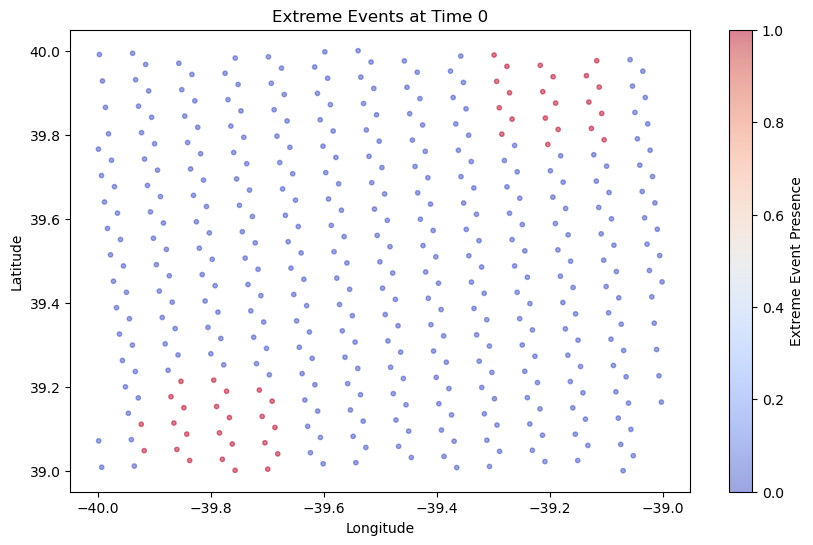

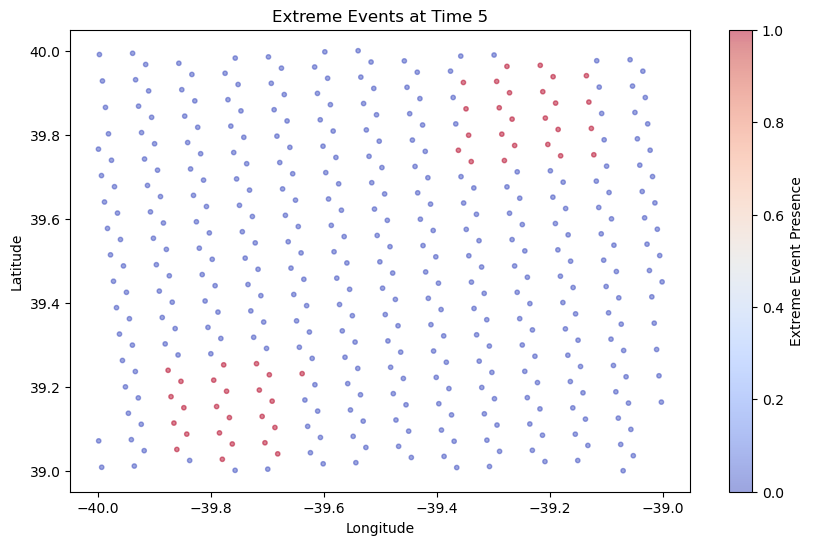

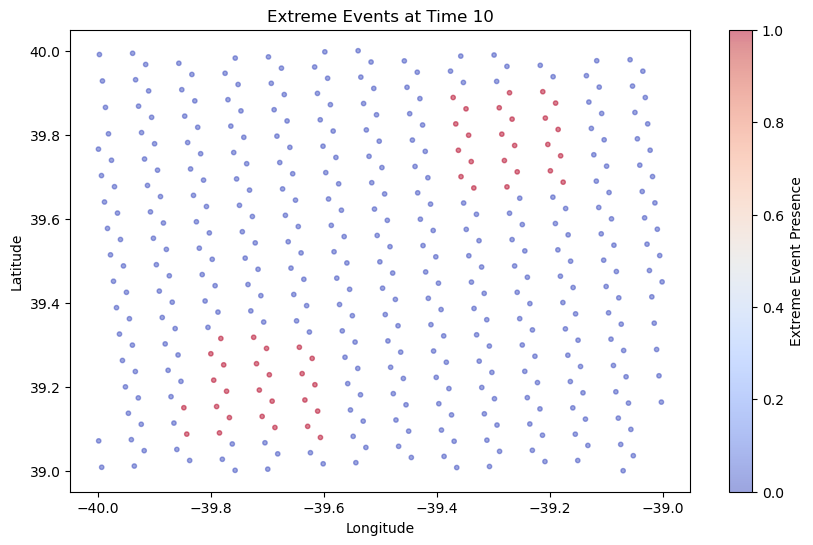

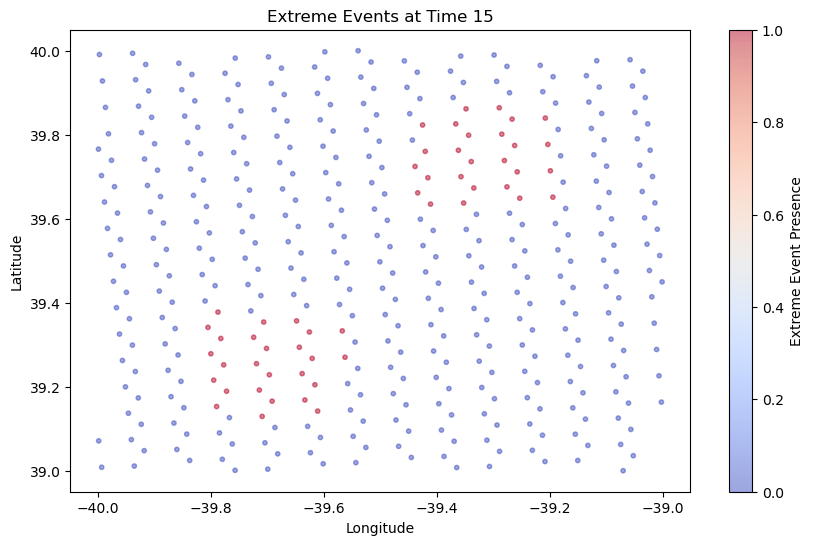

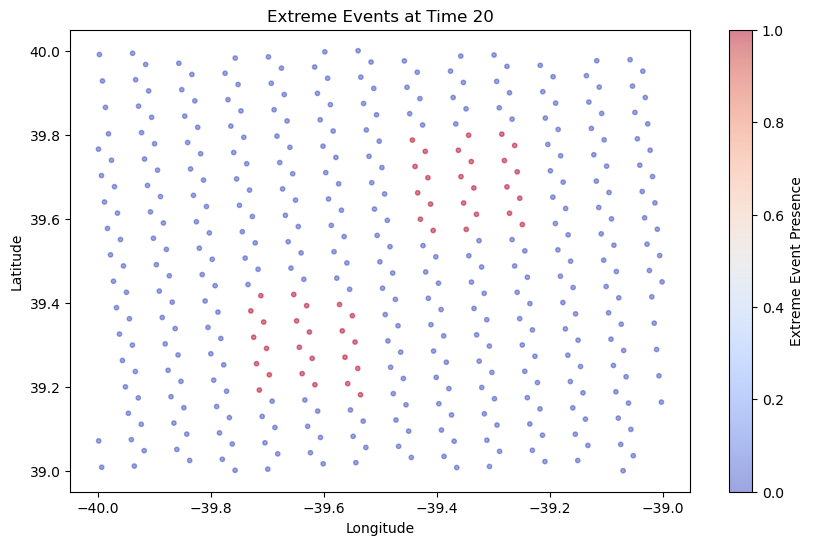

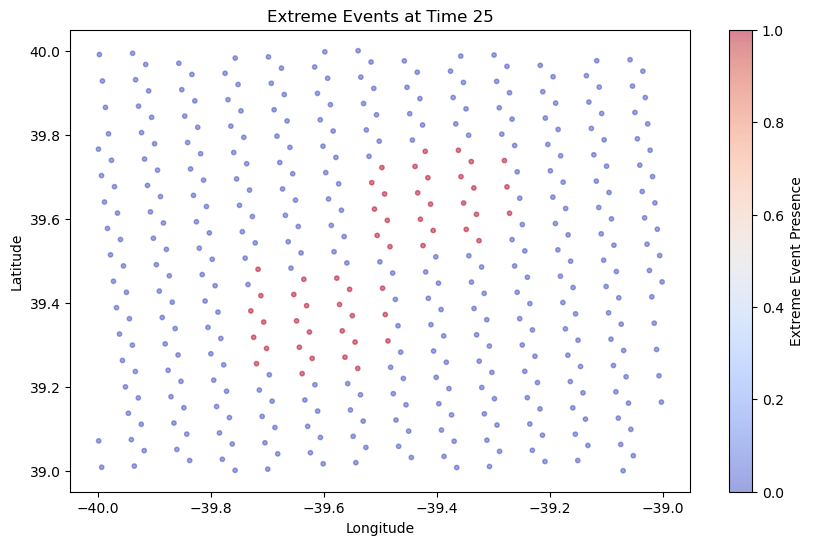

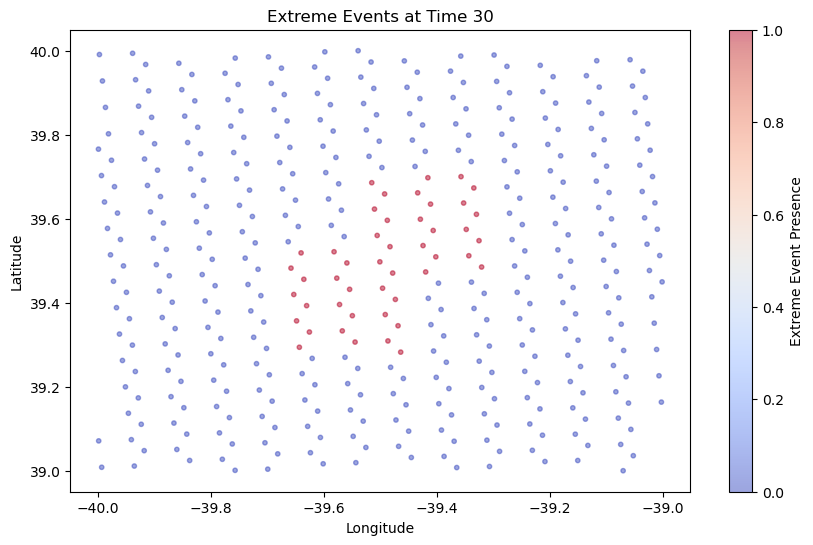

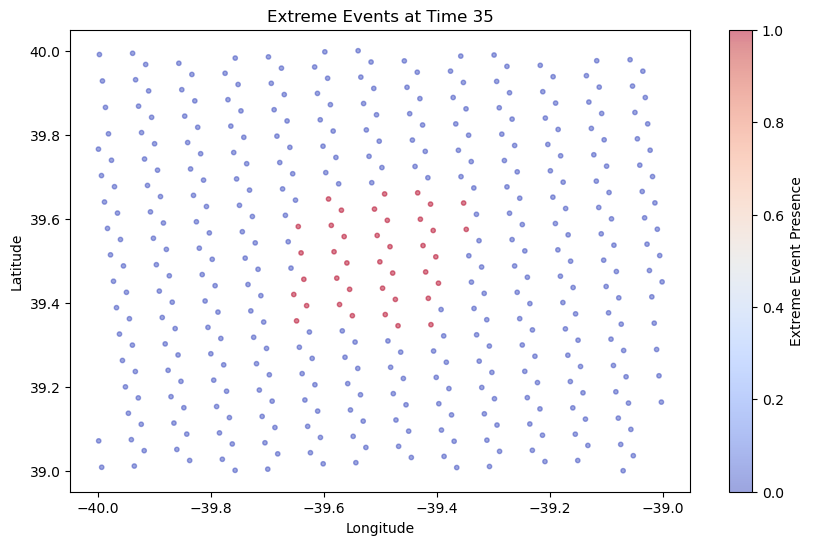

In [7]:
# Plot every few time slices (scatter plot)
import matplotlib.pyplot as plt

for i in range(0, n_times, 5):
    plt.figure(figsize=(10, 6))
    plt.scatter(
        extremes_subset["lon"].values,
        extremes_subset["lat"].values,
        c=extremes_subset["extreme_events"].values[i],
        cmap="coolwarm",
        s=10,
        alpha=0.5,
    )
    plt.title(f"Extreme Events at Time {i}")
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.colorbar(label="Extreme Event Presence")
    plt.show()

In [8]:
extremes_subset

<xarray.Dataset> Size: 215kB
Dimensions:         (ncells: 405, time: 100, nv: 3)
Coordinates:
    lat             (ncells) float32 2kB 39.97 39.99 39.93 ... 39.7 39.66 39.64
    lon             (ncells) float32 2kB -39.92 -39.94 -39.93 ... -39.1 -39.01
  * nv              (nv) int64 24B 0 1 2
  * time            (time) datetime64[ns] 800B 2000-01-01T23:59:59 ... 2000-0...
Dimensions without coordinates: ncells
Data variables:
    cell_areas      (ncells) float32 2kB 2.378e+07 2.379e+07 ... 2.37e+07
    dat_anomaly     (time, ncells) float32 162kB -0.03992 0.03355 ... 0.7733
    extreme_events  (time, ncells) bool 40kB False False False ... False False
    mask            (ncells) bool 405B True True True True ... True True True
    neighbours      (nv, ncells) int32 5kB 2 0 6 0 2 0 ... 399 399 0 402 402 402
    thresholds      (ncells) float32 2kB 1.779 1.719 1.72 ... 1.683 1.697 1.612
Attributes:
    detrend_orders:        [1]
    exact_percentile:      False
    force_zero_mean:       True
    method_anomaly:        detrended_baseline
    method_extreme:        global_extreme
    preprocessing_steps:   ['Removed polynomial trend orders=[1] & seasonal c...
    std_normalise:         False
    threshold_percentile:  95

In [9]:
extremes_subset.to_zarr(save_dir / "extremes_unstructured_merging.zarr", mode="w")